# SVM支持向量机
SVM支持向量机，有较为复杂的数学公式理论推导，这里重点在于简单介绍一下支持向量机的工作原理，并给出常见的代码（基于SVM的异或数据集划分），对于具体数学细节的推导为我们并不付出过多的精力来关注。

支持向量机（support vector machine）SVM是一类按监督学习方式对数据进行二元分类的广义线性分类器

距离超平面最近的这几个训练样本点被称为"支持向量"。

两个异类支持向量到超平面的距离之和为”间隔“。

我们求解的目标就是要找到具有"最大间隔"的一个划分超平面，用于二分类任务。

一开始为我们是假设的针对线性可分的数据，训练样本在样本空间或特征空间中是线性可分的，即存在一个超平面能将不同类的样本完全划分开。但是现实情况中的数据往往线性不可分，如本程序的”异或“数据集的划分，不具有线性可分性，因此就需要进行进一步改进。

可将样本从原始空间映射到一个更高维的特征空间，使得样本在这个特征空间内线性可分. 例如可将原始的二维空间映射到一个合适的三维空间，就能找到一个合适的划分超平面

### 如果原始空间是有限维，即属性数有限，那么一定存在一个高维特征空间使样本可分

所以，这个时候我们要借助一个”核函数“将特征映射到高维度，从而进行分类操作。

核函数有三种常见的，线性核函数、高斯核函数、多项式核函数。

线性核函数主要用于数据线性可分，通常是首先尝试用线性核函数进行分类。

高斯核函数是一种局部性较强的核函数，可以将一个样本映射到一个更高维的空间内，该核函数是应用最广泛的一个，无论样本大小均有较好的性能，且相对于多项式核函数的参数要少。

### 大多数情况下不知道选什么核函数时，优先使用高斯核函数

多项式核函数非常适合于正交归一化后的数据，可以实现将低纬的输入空间映射到高维的特征空间，但是多项式核函数的参数多，当多项式阶数较高时，核矩阵的元素值将趋于无穷大或者无穷小，计算复杂度非常大。

In [2]:
#导入需要的包
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC

### 绘制异或点决策的边界的函数

In [3]:
def plot_decision_regions(x,y,model,resolution=0.2):
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    x1_min,x1_max = x[:,0].min() - 1,x[:,0].max() + 1
    x2_min,x2_max = x[:,1].min() - 1,x[:,1].max() + 1
    xx1,xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),np.arange(x2_min,x2_max,resolution))
    z = model.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    z = z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,z,alpha=0.4,cmap=cmap)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    for idx,cl in enumerate(np.unique(y)):
        plt.scatter(x=x[y==cl,0],y=x[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

In [7]:
#设置随机数，保证每次代码生成的随机结果可以复现
np.random.seed(1)
#使numpy显示数组时不使用科学计数法
np.set_printoptions(suppress=True)
#生成标准正态分布（均值为 0，标准差为 1）中的随机数。它的返回值是一个200*2的标准正态分布随机数数组。
X_xor = np.random.randn(200,2)
print("标准正态分布数组X_xor为：\n",X_xor)
#切片操作，X_xor[:,0]表示在200*2的X_xor数组中取所有行的第一列数据（冒号表示所有行，0表示第一列）组成一个1*200的一维数组
print("X_xor数组的第一列数据X_xor[:,0]为：\n",X_xor[:,0])
#X_xor[:,1]同理，表示取200*2的X_xor数组中取所有行的第二列数据
#X_xor[:, 0] > 0：表示第一个特征值大于0的样本会返回 True，否则为 False。
#X_xor[:, 1] > 0：表示第二个特征值大于0的样本也会返回 True 或 False。
#np.logical_xor() 是计算逻辑异或的函数，两个值异或为 True 时返回 True，否则返回 False。最后生成标签y_xor。
y_xor = np.logical_xor(X_xor[:,0]>0,X_xor[:,1]>0)
#将逻辑值（True 或 False）转换为 1 或 -1，用来表示二分类标签。True 会变成 1，False 会变成 -1。
y_xor = np.where(y_xor,1,-1)
print("用于训练的标签y_xor为：\n",y_xor)

标准正态分布数组X_xor为：
 [[ 1.62434536 -0.61175641]
 [-0.52817175 -1.07296862]
 [ 0.86540763 -2.3015387 ]
 [ 1.74481176 -0.7612069 ]
 [ 0.3190391  -0.24937038]
 [ 1.46210794 -2.06014071]
 [-0.3224172  -0.38405435]
 [ 1.13376944 -1.09989127]
 [-0.17242821 -0.87785842]
 [ 0.04221375  0.58281521]
 [-1.10061918  1.14472371]
 [ 0.90159072  0.50249434]
 [ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]
 [-0.69166075 -0.39675353]
 [-0.6871727  -0.84520564]
 [-0.67124613 -0.0126646 ]
 [-1.11731035  0.2344157 ]
 [ 1.65980218  0.74204416]
 [-0.19183555 -0.88762896]
 [-0.74715829  1.6924546 ]
 [ 0.05080775 -0.63699565]
 [ 0.19091548  2.10025514]
 [ 0.12015895  0.61720311]
 [ 0.30017032 -0.35224985]
 [-1.1425182  -0.34934272]
 [-0.20889423  0.58662319]
 [ 0.83898341  0.93110208]
 [ 0.28558733  0.88514116]
 [-0.75439794  1.25286816]
 [ 0.51292982 -0.29809284]
 [ 0.48851815 -0.07557171]
 [ 1.13162939  1.51981682]
 [ 2.18557541 -1.39649634]
 [-1.44411381 -0.50446586]
 [ 0.160037

### 绘制所生成的异或数据集图像，X_xor第一列为横坐标,X_xor第二列为纵坐标

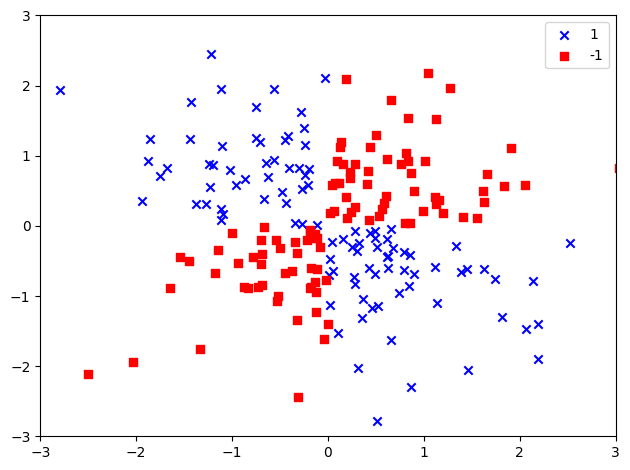

In [8]:
#绘制了所有y_xor值为1的数据点（蓝色星号）。
plt.scatter(X_xor[y_xor == 1,0],X_xor[y_xor == 1,1],c='b',marker='x',label='1')
##绘制了所有y_xor值为-1的数据点（红色方框）。
plt.scatter(X_xor[y_xor == -1,0],X_xor[y_xor == -1,1],c='r',marker='s',label='-1')
#设置x轴的显示范围为-3到3
plt.xlim([-3,3])
#设置y轴的显示范围为-3到3
plt.ylim([-3,3])
#添加图例，loc='best'表示Matplotlib会自动选择最佳位置放置图例
plt.legend(loc='best')
#自动调整子图参数, 使之填充整个图像区域。
plt.tight_layout()
#显示图表
plt.show()

## 构建SVM分类器
支持向量机Support Vector Machine，就是所谓的SVM，它指的是一系列的机器学习算法，根据解决问题的不同，分为SVC(分类)和SVR(回归)

SVC，Support Vector Classification，用于分类classification任务

SVR，Support Vector Regression，用于回归Regression任务

### 核函数（kernel）选择
‘linear’：线性核函数，速度快；只能处理数据集样本线性可分，不能处理线性不可分。

‘poly’：多项式核函数，可将数据集样本升维，从低维空间映射到高维空间；参数较多，计算量大

‘rbf’：高斯核函数，和多项式核函数一样，可将样本升维；相较于多项式核函数来说，参数较少；默认值

'sigmoid’：sigmoid 核函数；当选用 sigmoid 核函数时，SVM 可实现的是多层神经网络

‘precomputed’：核矩阵；使用用户给定的核函数矩阵(n*n)

### gamma值的选择
参数gamma主要是对低维的样本进行高度度映射。

gamma值越大映射的维度越高，训练的结果越好，但是越容易引起过拟合，即泛化能力低。

当gamma较大时，决策平面如一个梅花，分类的效果好，但是模型的鲁棒性不一定高。

### 正则化参数（C值）的选择
决策平面与支持向量之间有一个距离差，而在实际工程中，参数c正是影响了支持向量与决策平面之间的距离，具体效果为：

c越大，分类越严格，不能有错误，分类结果越好，相应的泛化能力降低

c越小，意味着有更大的错误容忍度，决策边界更大一些，即在训练时容忍一些样本的误差，拿一些边界更宽的样本作为支持向量。

## 实验1：高斯核函数、gamma设置为0.1

C:\Users\贾锦成\AppData\Local\Temp\ipykernel_22764\48357900.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=x[y==cl,0],y=x[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)


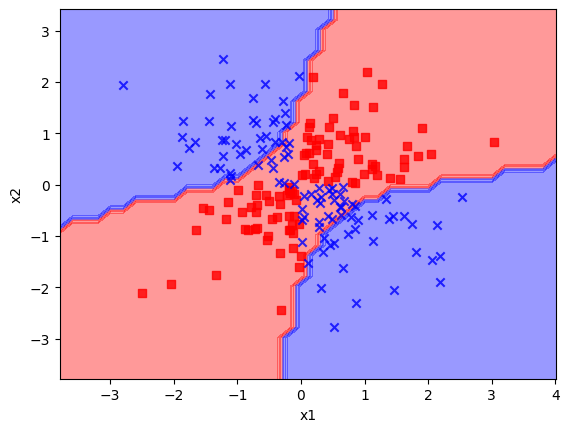

In [9]:
#kernel="rbf"使用的是径向基函数（Radial Basis Function, RBF）作为核函数，这里就是默认的高斯核函数
#random_state=0随机数种子确保了结果的可重复性，即每次运行代码时都会得到相同的结果。
#gamma=0.1是RBF核的系数，用于控制单个训练样本影响的范围；值越大，影响范围越小
#C=1.0是正则化参数，用于控制分类间隔和分类错误之间的权衡。默认是1。
svm = SVC(kernel="rbf",random_state=0,gamma=0.1,C=1.0)
#svm分类器使用构建好的数据集进行训练
svm.fit(X_xor,y_xor)
#绘制SVM决策边界
plot_decision_regions(X_xor,y_xor,svm)

## 实验2：高斯核函数、gamma设置为10

C:\Users\贾锦成\AppData\Local\Temp\ipykernel_22764\48357900.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=x[y==cl,0],y=x[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)


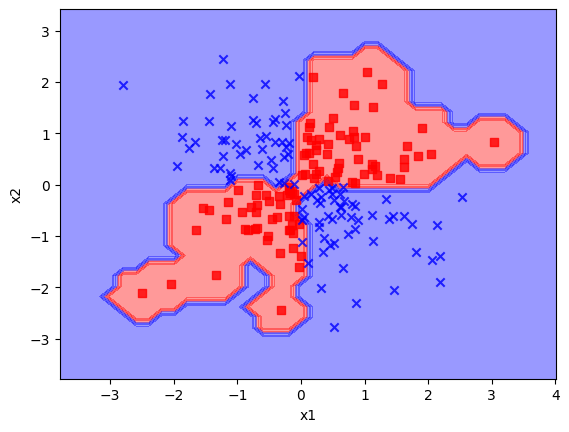

In [10]:
svm = SVC(kernel="rbf",random_state=0,gamma=10,C=1.0)
#svm分类器使用构建好的数据集进行训练
svm.fit(X_xor,y_xor)
#绘制SVM决策边界
plot_decision_regions(X_xor,y_xor,svm)

## 实验3：高斯核函数、gamma设置为100

C:\Users\贾锦成\AppData\Local\Temp\ipykernel_22764\48357900.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=x[y==cl,0],y=x[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)


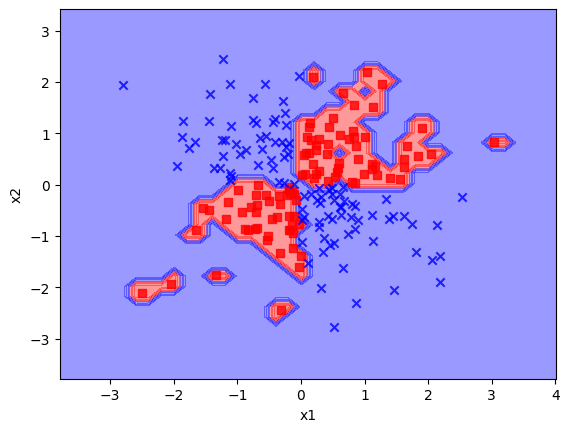

In [11]:
svm = SVC(kernel="rbf",random_state=0,gamma=100,C=1.0)
#svm分类器使用构建好的数据集进行训练
svm.fit(X_xor,y_xor)
#绘制SVM决策边界
plot_decision_regions(X_xor,y_xor,svm)

## 多项式核函数
### degree参数
degree参数支队多项式核函数有用，是指多项式核函数的阶数d

在多项式核函数中，度数决定了多项式的最高次幂。degree=2意味着使用的是二次多项式核。二次多项式核可以捕捉数据中的二次关系，适用于一些非线性可分的问题。
### coef0参数
coef0是指多项式核函数中的常数项。在多项式核函数中，coef0允许我们调整多项式的自由度，从而可能改变模型的拟合程度。

coef0=0意味着多项式中没有常数项。

## 实验4：多项式核函数、degree设置为2、gamma设置为0.1、coef0设置为0

C:\Users\贾锦成\AppData\Local\Temp\ipykernel_22764\48357900.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=x[y==cl,0],y=x[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)


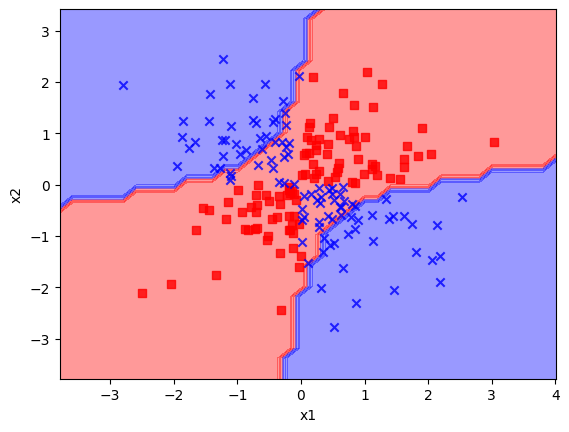

In [14]:
svm = SVC(kernel="poly",degree=2,gamma=0.1,coef0=0)
#svm分类器使用构建好的数据集进行训练
svm.fit(X_xor,y_xor)
#绘制SVM决策边界
plot_decision_regions(X_xor,y_xor,svm)

## 实验5：多项式核函数、degree设置为2、gamma设置为1、coef0设置为0

C:\Users\贾锦成\AppData\Local\Temp\ipykernel_22764\48357900.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=x[y==cl,0],y=x[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)


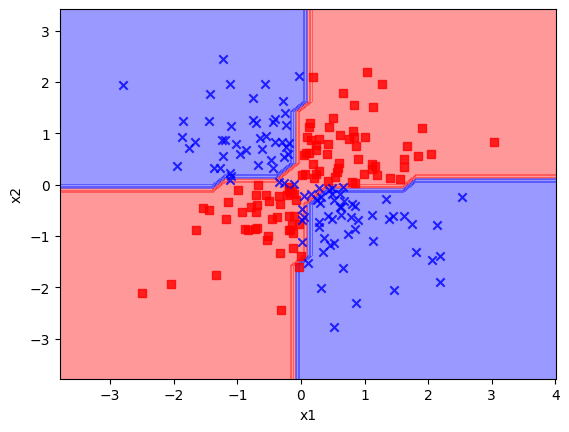

In [15]:
svm = SVC(kernel="poly",degree=2,gamma=1,coef0=0)
#svm分类器使用构建好的数据集进行训练
svm.fit(X_xor,y_xor)
#绘制SVM决策边界
plot_decision_regions(X_xor,y_xor,svm)

## 实验6：多项式核函数、degree设置为2、gamma设置为100、coef0设置为0

C:\Users\贾锦成\AppData\Local\Temp\ipykernel_22764\48357900.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x=x[y==cl,0],y=x[y==cl,1],alpha=0.8,c=cmap(idx),marker=markers[idx],label=cl)


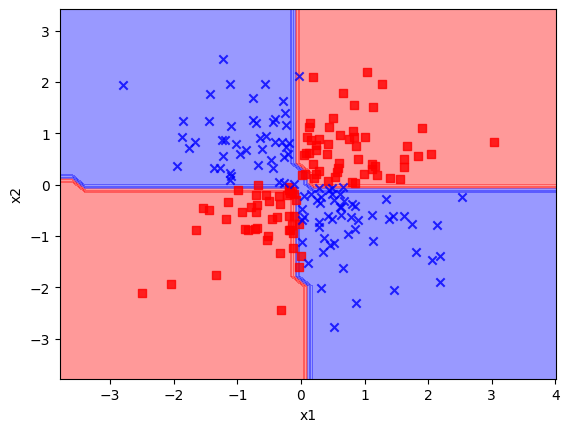

In [16]:
svm = SVC(kernel="poly",degree=2,gamma=100,coef0=0)
#svm分类器使用构建好的数据集进行训练
svm.fit(X_xor,y_xor)
#绘制SVM决策边界
plot_decision_regions(X_xor,y_xor,svm)